# 목차 

- [Titanic](#Titanic)
    - [Titanic 데이터셋의 기본 정보]
    - [탐색적 데이터 분석]
- [생존자 분류 모델](#생존자-분류-모델)
    - [분류 모델을 위한 전처리]
    - [분류 모델링]
- [데이터 변수 활용](#데이터-변수-활용)
    - [변수 활용]
    - [각 변수의 Coef 그래프]
- [모델 검증하기](#모델-검증하기)
    - [K-fold 교차 검증]
    - [학습 곡선 분석]

In [1]:
# %matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Titanic

### [Titanic 데이터셋의 기본 정보]

##### 데이터 변수 설명
- pclass : Passenger Class, 승객 등급
- survived : 생존 여부
- name : 승객 이름
- sex : 승객 성별
- age : 승객 나이
- sibsp : 탑승 한 형제/배우자 수
- parch : 탑승 한 부모/자녀 수
- ticket : 티켓 번호
- fare : 승객 지불 요금
- cabin : 선실 이름
- embarked : 승선항 (C = 쉘 부르그, Q = 퀸즈타운, S = 사우스 햄튼)
- body : 사망자 확인 번호
- home.dest : 고향/목적지

In [2]:
df_train = pd.read_csv("data/titanic_train2.csv")
df_test = pd.read_csv("data/titanic_test2.csv")
df_train.head(5)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,body,home.dest
0,2,1,"Mellinger, Miss. Madeleine Violet",female,13.0,0,1,250644,19.5000,NaN,S,NaN,"England / Bennington, VT"
1,2,1,"Wells, Miss. Joan",female,4.0,1,1,29103,23.0000,NaN,S,NaN,"Cornwall / Akron, OH"
2,2,1,"Duran y More, Miss. Florentina",female,30.0,1,0,SC/PARIS 2148,13.8583,NaN,C,NaN,"Barcelona, Spain / Havana, Cuba"
3,3,0,"Scanlan, Mr. James",male,NaN,0,0,36209,7.7250,NaN,Q,NaN,NaN
4,3,1,"Bradley, Miss. Bridget Delia",female,22.0,0,0,334914,7.7250,NaN,Q,NaN,"Kingwilliamstown, Co Cork, Ireland Glens Falls..."


In [3]:
print(df_train.info())
print("--------------------------------------------")
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     916 non-null    int64  
 1   survived   916 non-null    int64  
 2   name       916 non-null    object 
 3   sex        916 non-null    object 
 4   age        741 non-null    float64
 5   sibsp      916 non-null    int64  
 6   parch      916 non-null    int64  
 7   ticket     916 non-null    object 
 8   fare       916 non-null    float64
 9   cabin      214 non-null    object 
 10  embarked   914 non-null    object 
 11  body       85 non-null     float64
 12  home.dest  527 non-null    object 
dtypes: float64(3), int64(4), object(6)
memory usage: 93.2+ KB
None
--------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----

##### 불필요한 변수 제거

In [4]:
df_train = df_train.drop(['name', 'ticket', 'body', 'cabin', 'home.dest'], axis=1)
df_test = df_test.drop(['name', 'ticket', 'body', 'cabin', 'home.dest'], axis=1)

### [탐색적 데이터 분석]

0    563
1    353
Name: survived, dtype: int64


<AxesSubplot:>

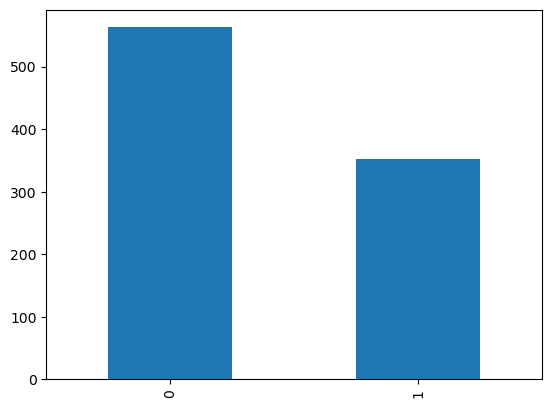

In [5]:
# 생존자 수
print(df_train['survived'].value_counts())
df_train['survived'].value_counts().plot.bar()

3    498
1    230
2    188
Name: pclass, dtype: int64


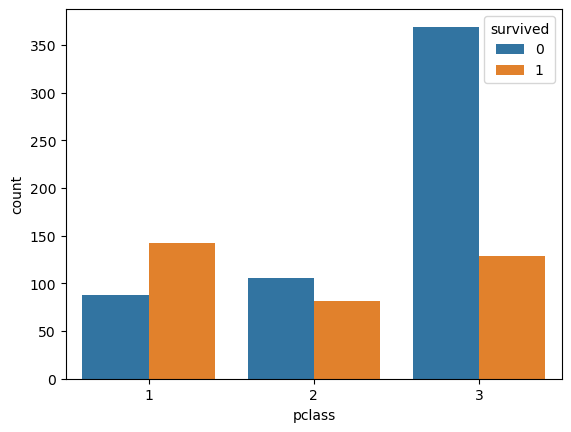

In [6]:
# pclass 별 생존자
print(df_train['pclass'].value_counts())
ax = sns.countplot(x='pclass', hue = 'survived',  data = df_train)

In [7]:
from scipy import stats

# 변수의 두 집단을 비교하는 함수 정의
def valid_features(df, col_name, distribution_check = True):
    
    # df에 대한 survived 분포표
    g = sns.FacetGrid(df, col='survived')
    g.map(plt.hist, col_name, bins=30)

    # df의 survived에 대한 집단 간 표준편차를 각각 출력합니다.
    titanic_survived = df[df['survived'] == 1]
    titanic_survived_static = np.array(titanic_survived[col_name])
    print("[survived == 1] std is", '%.2f' % np.std(titanic_survived_static))
    
    titanic_n_survived = df[df['survived'] == 0]
    titanic_n_survived_static = np.array(titanic_n_survived[col_name])
    print("[survived == 0] std is", '%.2f' % np.std(titanic_n_survived_static))
    
    
    # T-test로 두 집단의 평균 차이를 검정
    tTestResult = stats.ttest_ind(titanic_survived[col_name], titanic_n_survived[col_name])
    tTestResultDiffVar = stats.ttest_ind(titanic_survived[col_name], titanic_n_survived[col_name], equal_var = False)
    
    # T-통계량 및 P(유의확률)값 출력
    print("The T-statistic and p-value assuming equal variances is %.3f and %.3f." % tTestResult)
    print("The T-statistic and p-value not assuming equal variances is %.3f and %.3f" % tTestResultDiffVar)
    
    if distribution_check:
        # Shapiro-Wilk 검정 : 분포의 정규성 검증 (W-통계량 및 P(유의확률)값 출력)
        print("The W-statistic and p-value in Survived %.3f and %.3f" % stats.shapiro(titanic_survived[col_name]))
        print("The W-statistic and p-value in Non-Survived %.3f and %.3f" % stats.shapiro(titanic_n_survived[col_name]))

[survived == 1] std is 14.22
[survived == 0] std is 13.71
The T-statistic and p-value assuming equal variances is -0.546 and 0.585.
The T-statistic and p-value not assuming equal variances is -0.543 and 0.587
The W-statistic and p-value in Survived 0.982 and 0.001
The W-statistic and p-value in Non-Survived 0.968 and 0.000


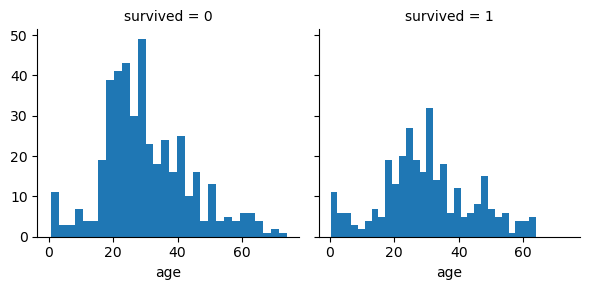

In [8]:
# age
valid_features(df_train[df_train['age'] > 0], 'age', distribution_check = True)

[survived == 1] std is 0.64
[survived == 0] std is 1.34
The T-statistic and p-value assuming equal variances is -2.118 and 0.034.
The T-statistic and p-value not assuming equal variances is -2.446 and 0.015
The W-statistic and p-value in Survived 0.656 and 0.000
The W-statistic and p-value in Non-Survived 0.492 and 0.000


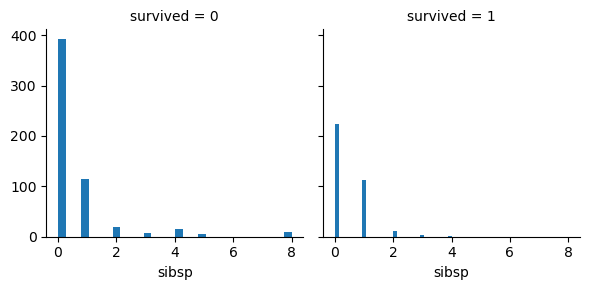

In [9]:
# sibsp
valid_features(df_train, 'sibsp', distribution_check = True)

[survived == 1] std is 0.88
[survived == 0] std is 0.75
The T-statistic and p-value assuming equal variances is -9.848 and 0.000.
The T-statistic and p-value not assuming equal variances is -9.507 and 0.000
The W-statistic and p-value in Survived 0.759 and 0.000
The W-statistic and p-value in Non-Survived 0.657 and 0.000


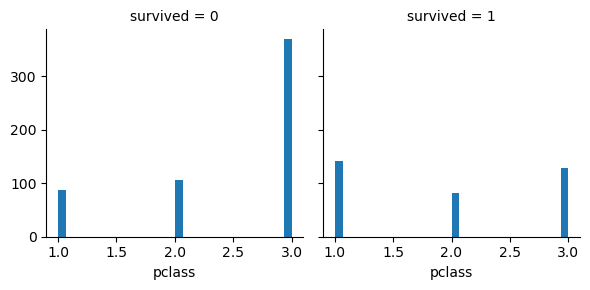

In [10]:
# pclass
valid_features(df_train, 'pclass', distribution_check=True)

[survived == 1] std is 0.74
[survived == 0] std is 0.89
The T-statistic and p-value assuming equal variances is 1.865 and 0.063.
The T-statistic and p-value not assuming equal variances is 1.942 and 0.052
The W-statistic and p-value in Survived 0.630 and 0.000
The W-statistic and p-value in Non-Survived 0.421 and 0.000


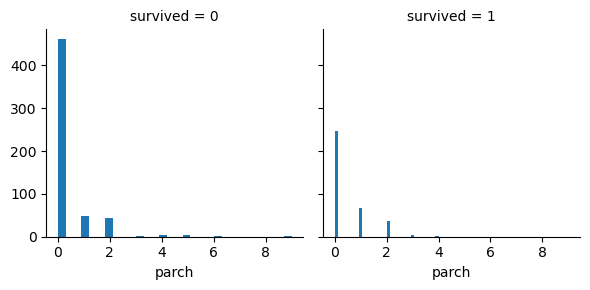

In [11]:
# parch
valid_features(df_train, 'parch', distribution_check=True)

[survived == 1] std is 60.68
[survived == 0] std is 33.65
The T-statistic and p-value assuming equal variances is 7.523 and 0.000.
The T-statistic and p-value not assuming equal variances is 6.657 and 0.000
The W-statistic and p-value in Survived 0.660 and 0.000
The W-statistic and p-value in Non-Survived 0.520 and 0.000


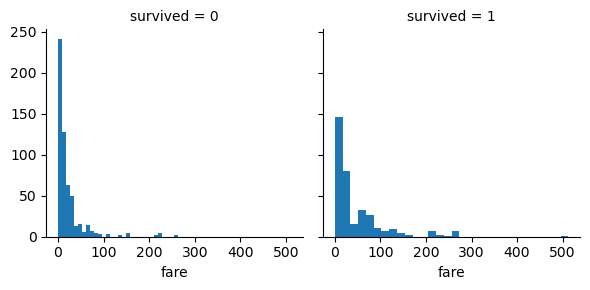

In [12]:
# fare
valid_features(df_train, 'fare', distribution_check=True)

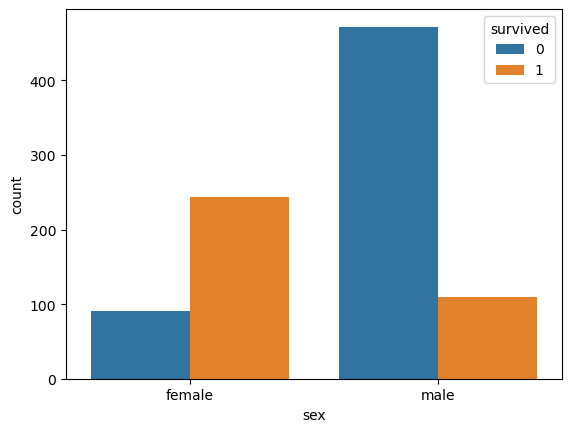

In [13]:
# 성별 간 survived
ax = sns.countplot(x='sex', hue = 'survived',  data = df_train)

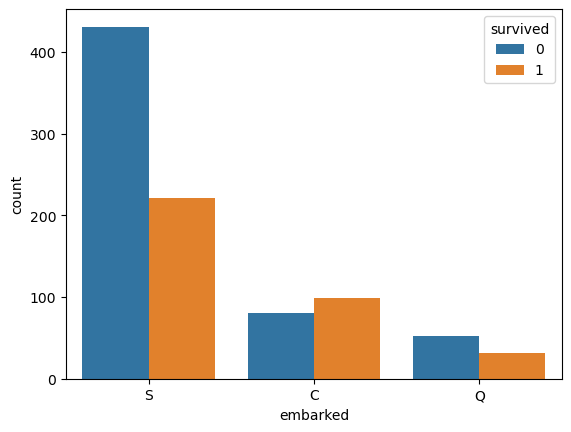

In [14]:
# embarked 간 survived
ax = sns.countplot(x='embarked', hue = 'survived',  data = df_train)

# 생존자 분류 모델

### [분류 모델을 위한 전처리]

In [15]:
df_train.describe()

,pclass,survived,age,sibsp,parch,fare
count,916.000000,916.000000,741.000000,916.000000,916.000000,916.000000
mean,2.292576,0.385371,30.231444,0.532751,0.371179,32.532050
std,0.842576,0.486949,13.934240,1.125957,0.837508,47.416524
min,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,21.000000,0.000000,0.000000,7.895800
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000
max,3.000000,1.000000,74.000000,8.000000,9.000000,512.329200


In [16]:
print(df_train.isnull().sum())
print('')
print(df_test.isnull().sum())

pclass        0
survived      0
sex           0
age         175
sibsp         0
parch         0
fare          0
embarked      2
dtype: int64

pclass       0
survived     0
sex          0
age         88
sibsp        0
parch        0
fare         0
embarked     0
dtype: int64


In [17]:
# age의 결측값을 평균값으로 대체 (결측치가 많음)
replace_mean = df_train[df_train['age'] > 0]['age'].mean()
df_train['age'] = df_train['age'].fillna(replace_mean)
df_test['age'] = df_test['age'].fillna(replace_mean)

In [18]:
# embarked의 결측값을 최빈값으로 대체 (범주형이며, 결측치수가 적음)
embarked_mode = df_train['embarked'].value_counts().index[0]
embarked_mode

'S'

In [19]:
df_train['embarked'] = df_train['embarked'].fillna(embarked_mode)
df_test['embarked'] = df_test['embarked'].fillna(embarked_mode)

In [20]:
# one-hot encoding을 위한 통합 DataFrame 생성
whole_df = df_train.append(df_test)
train_idx_num = len(df_train)

whole_df_encoded = pd.get_dummies(whole_df)

In [21]:
df_train = whole_df_encoded[:train_idx_num]
df_test = whole_df_encoded[train_idx_num:]

df_test.head()

,pclass,survived,age,sibsp,parch,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
0,3,0,38.000000,0,0,7.8958,0,1,0,0,1
1,2,1,21.000000,0,1,21.0000,1,0,0,0,1
2,2,0,42.000000,1,0,27.0000,0,1,0,0,1
3,3,0,30.231444,0,0,14.5000,0,1,0,0,1
4,2,0,25.000000,0,0,31.5000,0,1,0,0,1


In [22]:
df_train.loc[:, df_train.columns != 'survived'].values

array([[ 2.        , 13.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 2.        ,  4.        ,  1.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 2.        , 30.        ,  1.        , ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 3.        , 30.23144399,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 2.        , 20.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 3.        , 32.        ,  1.        , ...,  0.        ,
         1.        ,  0.        ]])

In [23]:
# 데이터를 학습 데이터셋, 테스트 데이터셋으로 분리
x_train, y_train = df_train.loc[:, df_train.columns != 'survived'].values, df_train['survived'].values
x_test, y_test = df_test.loc[:, df_test.columns != 'survived'].values, df_test['survived'].values

In [24]:
x_train
# y_train
# x_test
# y_test

array([[ 2.        , 13.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 2.        ,  4.        ,  1.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 2.        , 30.        ,  1.        , ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 3.        , 30.23144399,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 2.        , 20.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 3.        , 32.        ,  1.        , ...,  0.        ,
         1.        ,  0.        ]])

### [분류 모델링]

##### 분류 모델의 여러가지 평가 방법들

![confusion matrix](https://rasbt.github.io/mlxtend/user_guide/evaluate/confusion_matrix_files/confusion_matrix_1.png)

- [Confusion Matrix](https://frhyme.github.io/machine-learning/clf_%ED%8F%89%EA%B0%80%ED%95%98%EA%B8%B0/) 기반
    - Accuracy (정확도) : TP+TN / TP+TN+FP+FN
    - Precision (정밀도) : TP / TP+FP
    - Recall (재현도) : TP / TP+FN
    - F1 score : 정밀도와 재현도의 조화 평균값
    - Specificity 특이도 : TN / TN+FP
    - ROC (Receiver Operating Characteristic) curve : 재현도(민감도)와 특이도를 고려 종합적인 모델 성능
    - AUC (Area Under the Curve) : ROC 그래프의 넓이를 계산 성능지표, 1에 가까울수록 좋은 분류 모델

##### Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 학습
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)

# 예측
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:,1]

# 성능 평가
# 테스트셋에 대한 accuracy, precision, recall, f1 값
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))

accuracy: 0.80
Precision : 0.756
Recall : 0.673
F1 : 0.712


In [26]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix를 출력합니다.
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[214  32]
 [ 48  99]]


##### Logistic Regression model AUC

AUC : 0.838


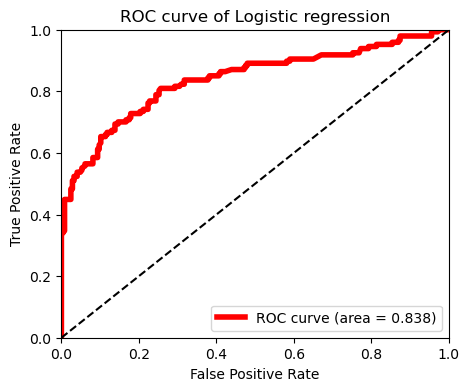

In [27]:
from sklearn.metrics import roc_curve, roc_auc_score

# AUC
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" % roc_auc)

# ROC curve 그래프
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, 
         color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc="lower right")

##### Decision Tree

In [28]:
from sklearn.tree import DecisionTreeClassifier

# 학습
dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)

# 예측
y_pred = dtc.predict(x_test)
y_pred_probability = dtc.predict_proba(x_test)[:,1]

# 성능 평가
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))

accuracy: 0.75
Precision : 0.681
Recall : 0.639
F1 : 0.660


AUC : 0.745


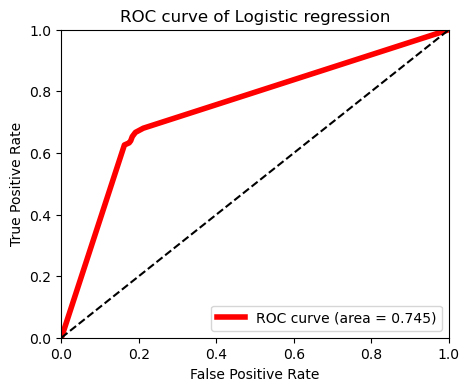

In [29]:
# AUC
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" % roc_auc)

# ROC curve 그래프
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, 
         color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc="lower right")

# 데이터 변수 활용

### [변수 활용]

In [30]:
# 데이터 로드
df_train = pd.read_csv("data/titanic_train2.csv")
df_test = pd.read_csv("data/titanic_test2.csv")
df_train = df_train.drop(['ticket', 'body', 'home.dest'], axis=1)
df_test = df_test.drop(['ticket', 'body', 'home.dest'], axis=1)

In [31]:
# age 결측값을 평균값으로 대체
replace_mean = df_train[df_train['age'] > 0]['age'].mean()
df_train['age'] = df_train['age'].fillna(replace_mean)
df_test['age'] = df_test['age'].fillna(replace_mean)

In [32]:
# embarked의 결측값을 최빈값으로 대체
embarked_mode = df_train['embarked'].value_counts().index[0]
df_train['embarked'] = df_train['embarked'].fillna(embarked_mode)
df_test['embarked'] = df_test['embarked'].fillna(embarked_mode)

In [33]:
# one-hot encoding을 위한 통합 DataFrame 생성
whole_df = df_train.append(df_test)
train_idx_num = len(df_train)

whole_df.head()

,pclass,survived,name,sex,age,sibsp,parch,fare,cabin,embarked
0,2,1,"Mellinger, Miss. Madeleine Violet",female,13.000000,0,1,19.5000,NaN,S
1,2,1,"Wells, Miss. Joan",female,4.000000,1,1,23.0000,NaN,S
2,2,1,"Duran y More, Miss. Florentina",female,30.000000,1,0,13.8583,NaN,C
3,3,0,"Scanlan, Mr. James",male,30.231444,0,0,7.7250,NaN,Q
4,3,1,"Bradley, Miss. Bridget Delia",female,22.000000,0,0,7.7250,NaN,Q


##### cabin

In [34]:
# cabin 고유값 확인
print(whole_df['cabin'].value_counts()[:10])
whole_df['cabin'].isnull().sum()

C23 C25 C27        6
B57 B59 B63 B66    5
G6                 5
F4                 4
B96 B98            4
F33                4
C78                4
D                  4
F2                 4
C22 C26            4
Name: cabin, dtype: int64


1014

In [35]:
# 결측치를 X로 대체
whole_df['cabin'] = whole_df['cabin'].fillna('X')
whole_df['cabin']

0        X
1        X
2        X
3        X
4        X
      ... 
388      X
389      X
390      X
391    F38
392      X
Name: cabin, Length: 1309, dtype: object

In [36]:
# cabin 의 첫 번째 문자 추출
whole_df['cabin'] = whole_df['cabin'].apply(lambda x: x[0])

In [37]:
whole_df['cabin'].value_counts()[:10]

X    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: cabin, dtype: int64

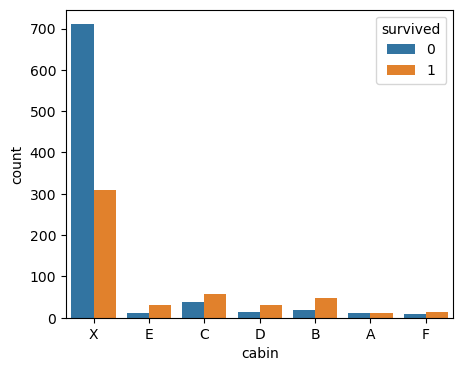

In [38]:
# 추출한 문자 중, G와 T는 수가 너무 적기 때문에, X로 대체
whole_df['cabin'] = whole_df['cabin'].replace({"G":"X", "T":"X"})

ax = sns.countplot(x='cabin', hue = 'survived',  data = whole_df)
plt.show()

##### name

In [39]:
# 이름에서 호칭만 추출
name_grade = whole_df['name'].apply(lambda x : x.split(", ",1)[1].split(".")[0])
name_grade = name_grade.unique().tolist()
print(name_grade)

['Miss', 'Mr', 'Master', 'Mrs', 'Dr', 'Mlle', 'Col', 'Rev', 'Ms', 'Mme', 'Sir', 'the Countess', 'Dona', 'Jonkheer', 'Lady', 'Major', 'Don', 'Capt']


In [40]:
# 호칭에 따라 지위를 정의
grade_dict = {'A': ['Rev', 'Col', 'Major', 'Dr', 'Capt', 'Sir'], # 명예직
              'B': ['Ms', 'Mme', 'Mrs', 'Dona'],                 # 여성
              'C': ['Jonkheer', 'the Countess'],                 # 귀족 또는 작위
              'D': ['Mr', 'Don'],                                # 남성
              'E': ['Master'],                                   # 젊은남성
              'F': ['Miss', 'Mlle', 'Lady']}                     # 젊은 여성

# 정의한 지위에 따라, A~F 로 다시 정의하는 함수 생성
def give_grade(x):
    grade = x.split(", ", 1)[1].split(".")[0]
    for key, value in grade_dict.items():
        for title in value:
            if grade == title:
                return key
    return 'G'
    
# 함수 적용
whole_df['name'] = whole_df['name'].apply(lambda x: give_grade(x))
print(whole_df['name'].value_counts())

D    758
F    263
B    201
E     61
A     24
C      2
Name: name, dtype: int64


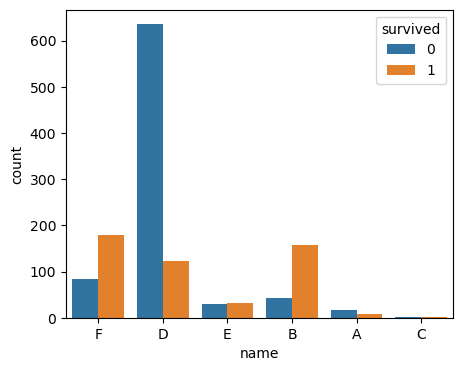

In [41]:
ax = sns.countplot(x='name', hue = 'survived',  data = whole_df)
plt.show()

In [42]:
# survived에 대한 name의 분포차이
from scipy import stats

chis_1 = stats.chisquare(whole_df[whole_df['survived']==1]['name'].value_counts().sort_index())
chis_0 = stats.chisquare(whole_df[whole_df['survived']==0]['name'].value_counts().sort_index())
print("statistic = %.3f, p-value = %.3f" % chis_1)
print("statistic = %.3f, p-value = %.3f" % chis_0)

statistic = 377.920, p-value = 0.000
statistic = 2256.169, p-value = 0.000


##### one-hot encoding

In [43]:
# one-hot encoding
whole_df_encoded = pd.get_dummies(whole_df)
df_train = whole_df_encoded[:train_idx_num]
df_test = whole_df_encoded[train_idx_num:]

df_train.head()

,pclass,survived,age,sibsp,parch,fare,name_A,name_B,name_C,name_D,...,cabin_A,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_X,embarked_C,embarked_Q,embarked_S
0,2,1,13.000000,0,1,19.5000,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,2,1,4.000000,1,1,23.0000,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,2,1,30.000000,1,0,13.8583,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,3,0,30.231444,0,0,7.7250,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
4,3,1,22.000000,0,0,7.7250,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


##### 모델링

In [44]:
# 데이터 split
x_train, y_train = df_train.loc[:, df_train.columns != 'survived'].values, df_train['survived'].values
x_test, y_test = df_test.loc[:, df_test.columns != 'survived'].values, df_test['survived'].values

In [45]:
# 로지스틱 회귀 모델 학습
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)

# 예측
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:,1]

# 성능 평가
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred)) # AUC (Area Under the Curve) & ROC curve

accuracy: 0.79
Precision : 0.736
Recall : 0.701
F1 : 0.718


In [46]:
# AUC
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" % roc_auc)

AUC : 0.853


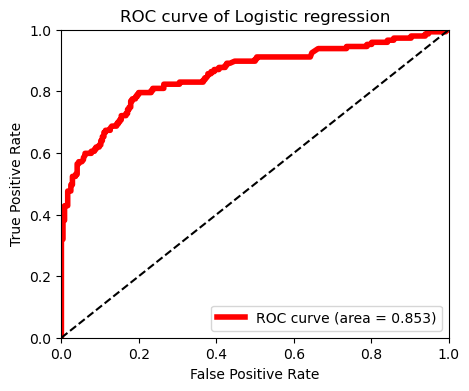

In [47]:
# ROC curve 그래프
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, 
         color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc="lower right")

### [각 변수의 Coef 그래프]

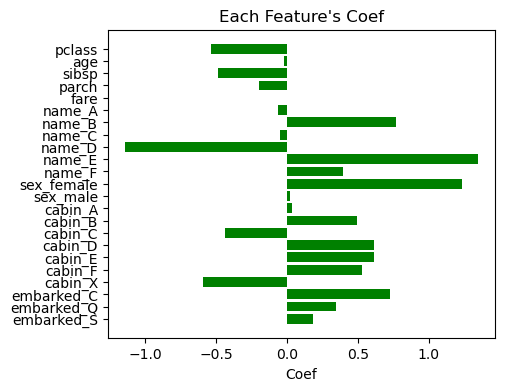

In [48]:
# survived 를 제외한 모든 변수를 리스트로 반환 (y축)
cols = df_train.columns.tolist()
cols.remove('survived')
y_pos = np.arange(len(cols))

# 각 변수별 회귀 분석 계수(Coef) (x축)
fig, ax = plt.subplots()
ax.barh(y_pos, lr.coef_[0], align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(cols)
ax.invert_yaxis()
ax.set_xlabel('Coef')
ax.set_title("Each Feature's Coef")

plt.show()

# 모델 검증하기

### [K-fold 교차]

참고 : [K Folds Cross Validation Method](https://nonmeyet.tistory.com/entry/KFold-Cross-Validation%EA%B5%90%EC%B0%A8%EA%B2%80%EC%A6%9D-%EC%A0%95%EC%9D%98-%EB%B0%8F-%EC%84%A4%EB%AA%85)

- K-fold 교차 검증을 통한 과적합 검증

In [49]:
from sklearn.model_selection import KFold

k = 5
cv = KFold(k, shuffle=True, random_state=0)
acc_history = []

# K-fold를 5번의 분할 학습 반복
for i, (train_data_row, test_data_row) in enumerate(cv.split(whole_df_encoded)):

    # 5개 fold 중 4 : 1로 train test split.
    # 매 반복시마다, 테스트 데이터셋 변경
    df_train = whole_df_encoded.iloc[train_data_row]
    df_test = whole_df_encoded.iloc[test_data_row]
    
    # y : survived, x : 나머지 변수
    splited_x_train, splited_y_train = df_train.loc[:, df_train.columns != 'survived'].values, df_train['survived'].values
    splited_x_test, splited_y_test = df_test.loc[:, df_test.columns != 'survived'].values, df_test['survived'].values
    
    # 모델 학습
    lr = LogisticRegression(random_state=0)
    lr.fit(splited_x_train, splited_y_train)
    y_pred = lr.predict(splited_x_test)
    
    # Accuracy
    splited_acc = accuracy_score(splited_y_test, y_pred)
    acc_history.append(splited_acc)

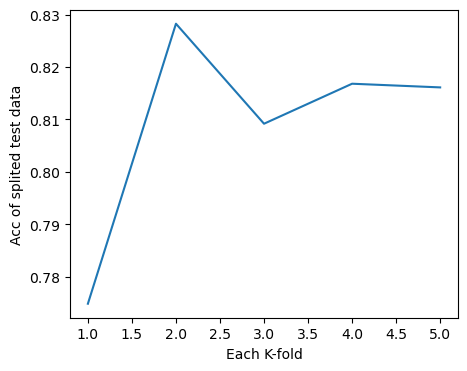

In [50]:
# Acc 결과 그래프
plt.xlabel("Each K-fold")
plt.ylabel("Acc of splited test data")
plt.plot(range(1, k+1), acc_history)

### [학습 곡선 분석]

In [51]:
# pip install scikit-plot

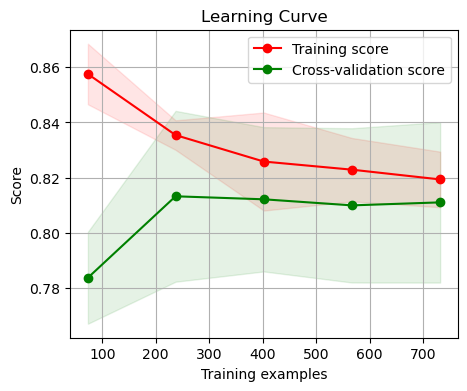

In [52]:
# 학습 데이터와 테스트 데이터의 점수가 벌어지는 과적합에 대한 학습곡선 관찰
# 학습 데이터 샘플의 개수가 증가함에 따라 학습과 테스트 두 점수가 어떻게 변화하는지 관찰한 그래프
# 데이터가 300개 이상인 경우에는 과적합의 위험이 낮아진다는 것

import scikitplot as skplt
skplt.estimators.plot_learning_curve(lr, x_train, y_train)
plt.show()